# Hyperbatch Efficiency Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# this sets up the Matplotlib interactive windows:
%matplotlib widget

`hyperbatch_efficinecy` sums the batch size calculations from the modified samplers
and returns `total_samples_for_regular_batch / total_samples_for_hyperbatch

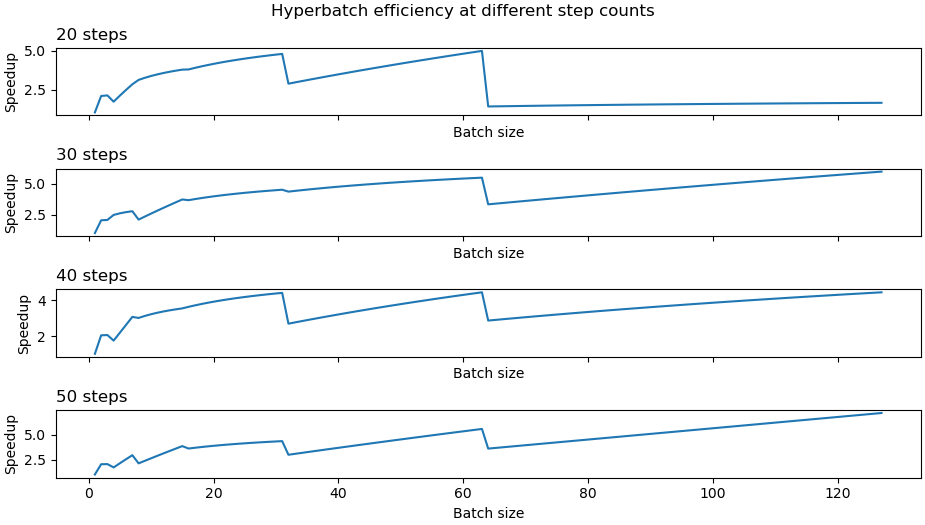

In [41]:
def hyperbatch_efficiency(batch_size, num_steps):
    current_batch_size = 1
    current_batch_size_log2 = 0
    batch_size_log2 = batch_size.bit_length()
    batch_size_leftover = 0
    if 2 ** batch_size_log2 != batch_size:
        batch_size_log2 -= 1
        batch_size_leftover = batch_size - 2 ** batch_size_log2

    # number of steps between doubling
    num_sub_steps = batch_size_log2 + 1
    sub_step_size = num_steps // num_sub_steps
    if num_steps % num_sub_steps:
        sub_step_final = sub_step_size * num_sub_steps
    else:
        sub_step_final = sub_step_size * batch_size_log2

    total_image_steps = 0
    for i in range(num_steps - 1):
        if i != 0 and i % sub_step_size == 0:
            if i == sub_step_final:
                appended_size = batch_size_leftover
            else:
                appended_size = None

            current_batch_size_log2 += 1
            if appended_size is None:
                current_batch_size = 2 * current_batch_size
            else:
                current_batch_size = current_batch_size + appended_size

        total_image_steps += current_batch_size

    return float(batch_size * num_steps) / total_image_steps

plt.close('all')
max_batch_size = 128
batch_size_range = range(1, max_batch_size)
fig, axs = plt.subplots(4, 1, sharex=True, constrained_layout=True)
fig.set_size_inches(9.25, 5.25)
fig.suptitle('Hyperbatch efficiency at different step counts')
for i, ax in enumerate(axs):
    num_steps = 10 * (i + 2)
    ax.set_title(f"{num_steps} steps", loc='left')
    ax.plot(batch_size_range, list(map(lambda x: batch_efficiency(x, num_steps), batch_size_range)))
    ax.set_xlabel('Batch size')
    # xticks = range(1, max_batch_size, 10)
    # ax.set_xticks(xticks)
    ax.set_ylabel('Speedup')
